# Verification

This MMS case verifies the implementation of the Surface Kinetics boundary condition in FESTIM. We will consider a time-dependent case of hydrogen diffusion on domain $\Omega: x\in[0,1] \cup t\in[0, 5]$ with a homogeneous diffusion coefficient $D$, and a Dirichlet boundary condition on the rear domain side.

The problem is:

\begin{align}
    &\dfrac{\partial c_\mathrm{m}}{\partial t} = \nabla\cdot\left(D\nabla c_\mathrm{m} \right) + S \quad \textrm{ on } \Omega, \\
    &-D \nabla c_\mathrm{m} \cdot \mathbf{n} = \lambda_{\mathrm{IS}} \dfrac{\partial c_{\mathrm{m}}}{\partial t} + J_{\mathrm{bs}} - J_{\mathrm{sb}} \quad \textrm{ at } x=0, \\
    &c_\mathrm{m} = c_\mathrm{m, 0} \quad \textrm{ at } x=1, \\
    &c_\mathrm{m} = c_\mathrm{m, 0} \quad \textrm{ at } t=0, \\
    &\dfrac{d c_\mathrm{s}}{d t} = J_{\mathrm{bs}} - J_{\mathrm{sb}} + J_{\mathrm{vs}}  \quad \textrm{ at } x=0, \\
    &c_\mathrm{s}= c_\mathrm{s, 0}\quad \textrm{ at } t=0, \\
\end{align}

with $J_{\mathrm{bs}} = k_{\mathrm{bs}} c_{\mathrm{m}} \left(1 - \dfrac{c_\mathrm{s}}{n_{\mathrm{surf}}}\right)$, $J_{\mathrm{sb}} = k_{\mathrm{sb}} c_{\mathrm{s}} \left(1 - \dfrac{c_{\mathrm{m}}}{n_\mathrm{IS}}\right)$.

The manufactured exact solution for mobile concentration is:
\begin{equation*}
c_\mathrm{m, exact}=1+2x^2+x+2t.
\end{equation*}

For this problem, we choose:
\begin{align*}
& k_{\mathrm{bs}}=3 \\
& k_{\mathrm{sb}}=2 \frac{n_\mathrm{IS}}{n_\mathrm{surf}} \\
& n_{\mathrm{IS}} = 20 \\
& n_{\mathrm{surf}} = 5 \\
& D = 7 \\
& \lambda_\mathrm{IS} = 2
\end{align*}

Injecting these parameters and the exact solution for solute H, we obtain:

\begin{align*}
& S = 2(1-2D) \\
& J_{\mathrm{vs}}=2n_\mathrm{surf}\dfrac{6n_\mathrm{IS}-2\lambda_\mathrm{IS}+D}{(2n_\mathrm{IS}+1+2t)^2}+2\lambda_\mathrm{IS}-D \\
& c_\mathrm{s, exact}=n_\mathrm{surf}\dfrac{3(1+2t)+2\lambda_\mathrm{IS}-D}{2n_\mathrm{IS}+1+2t} \\
& c_\mathrm{s,0}=c_\mathrm{s, exact} \\
& c_\mathrm{m,0}=c_\mathrm{m, exact}
\end{align*}

We can then run a FESTIM model with these values and compare the numerical solutions with $c_\mathrm{m, exact}$ and $c_\mathrm{s, exact}$.

## FESTIM model

In [1]:
import festim as F
import matplotlib.pyplot as plt
import numpy as np

n_IS = 20
n_surf = 5
D = 7
lambda_IS = 2
k_bs = 3
k_sb = 2 * n_IS / n_surf

solute_source = 2 * (1 - 2 * D)

exact_solution_cm = lambda x, t: 1 + 2 * x**2 + x + 2 * t
exact_solution_cs = (
    lambda t: n_surf * (3 * (1 + 2 * t) + 2 * lambda_IS - D) / (2 * n_IS + 1 + 2 * t)
)

solute_source = 2 * (1 - 2 * D)


def J_vs(T, surf_conc, solute, t):
    return (
        2 * n_surf * (6 * n_IS - 2 * lambda_IS + D) / (2 * n_IS + 1 + 2 * t) ** 2
        + 2 * lambda_IS
        - D
    )


def run_sim(N_mesh, time_step, export_times=None):
    # Create the FESTIM model
    my_model = F.Simulation()

    my_model.mesh = F.MeshFromVertices(np.linspace(0, 1, int(N_mesh)))

    my_model.sources = [F.Source(solute_source, volume=1, field="solute")]

    my_model.boundary_conditions = [
        F.DirichletBC(
            surfaces=[2], value=exact_solution_cm(x=F.x, t=F.t), field="solute"
        ),
        F.SurfaceKinetics(
            k_sb=k_sb,
            k_bs=k_bs,
            lambda_IS=lambda_IS,
            n_surf=n_surf,
            n_IS=n_IS,
            J_vs=J_vs,
            surfaces=1,
            initial_condition=exact_solution_cs(t=0),
            t=F.t,
        ),
    ]

    my_model.initial_conditions = [
        F.InitialCondition(field="solute", value=exact_solution_cm(x=F.x, t=F.t))
    ]

    my_model.materials = F.Material(id=1, D_0=D, E_D=0)

    my_model.T = 300  # this is ignored since no parameter is T-dependent

    my_model.settings = F.Settings(
        absolute_tolerance=1e-10, relative_tolerance=1e-10, transient=True, final_time=5
    )

    my_model.dt = F.Stepsize(initial_value=time_step, milestones=export_times)

    derived_quantities = F.DerivedQuantities(
        [F.AdsorbedHydrogen(surface=1)], show_units=True
    )

    TXT = F.TXTExport(
        "solute", filename="./mobile_conc.txt", times=export_times, write_at_last=True
    )
    my_model.exports = [TXT, derived_quantities]

    my_model.initialise()
    my_model.run()
    return derived_quantities, TXT

/home/vvkulagin/anaconda3/envs/PhD-env/lib/python3.11/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Comparison

In [2]:
from pypalettes import load_cmap

cmap = load_cmap("Sunset2", reverse=False)

mpl_params = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [
            r"\usepackage{siunitx}",
            r"\sisetup{detect-all}",
            r"\usepackage{amsmath}",
            r"\usepackage[utf8]{inputenc}",
            r"\usepackage[russian]{babel}",
        ]
    ),
    "axes.spines.right": False,
    "axes.spines.top": False,
    "font.family": "Times New Roman",
    "font.size": 12,
    "legend.frameon": False,
}

plt.rcParams.update(mpl_params)
mm2inch = 1e-1 / 2.54


def norm(x, c_comp, c_ex):
    return np.sqrt(np.trapz(y=(c_comp - c_ex) ** 2, x=x))

In [3]:
export_times = [1, 2, 3, 4, 5]
adsorbed_data, solute_data = run_sim(1000, 5e-3, export_times)
solute_data = solute_data.data

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
100.0 %        5.0e+00 s    Elapsed time so far: 16.8 s


L2 error for cs: 4.36e-05


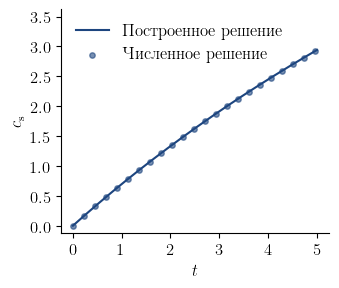

In [4]:
fig, ax = plt.subplots(figsize=(88 * mm2inch, 74 * mm2inch))

c_s_computed = adsorbed_data[0].data
t = adsorbed_data[0].t

ax.plot(
    t,
    exact_solution_cs(np.array(t)),
    label="Построенное решение",
    color=cmap(0),
    lw=1.5,
)
ax.scatter(
    t[::45],
    c_s_computed[::45],
    label="Численное решение",
    alpha=0.6,
    s=15,
    color=cmap(0),
)
ax.set_ylabel(r"$c_\mathrm{s}$")
ax.set_xlabel("$t$")
ax.set_ylim(-0.125, 3.5 + 0.125)
ax.set_xticks([i for i in range(6)])
ax.set_yticks([i * 0.5 for i in range(8)])
ax.legend(loc="upper left")

print(f"L2 error for cs: {norm(t, c_s_computed, exact_solution_cs(t=np.array(t))):.2e}")

plt.savefig("../../../Thesis/images/MMS_b.pdf", bbox_inches="tight", pad_inches=0.02)
plt.show()

L2 error for cm at t=1: 1.20e-05
L2 error for cm at t=2: 1.19e-05
L2 error for cm at t=3: 1.05e-05
L2 error for cm at t=4: 9.25e-06
L2 error for cm at t=5: 8.17e-06


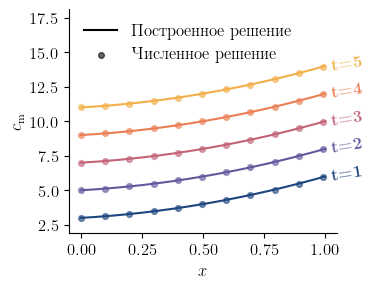

In [5]:
fig, ax = plt.subplots(figsize=(88 * mm2inch, 74 * mm2inch))

plot_times = [1, 2, 3, 4, 5]
for i, t in enumerate(plot_times):
    x = solute_data[:, 0]
    y = solute_data[:, i + 1]

    ax.plot(x, exact_solution_cm(np.array(x), t), color=cmap(i), lw=1.5)

    ax.text(
        1.02,
        exact_solution_cm(1.04, t),
        rf"$\textbf{{t={t}}}$",
        ha="left",
        va="center",
        rotation=9,
        color=cmap(i),
    )

    ax.scatter(
        x[::99],
        y[::99],
        s=17,
        color=cmap(i),
        alpha=0.6,
    )

    print(
        f"L2 error for cm at t={t}: {norm(np.array(x), np.array(y), exact_solution_cm(x=np.array(x), t=t)):.2e}"
    )

c_s_computed = adsorbed_data[0].data
t = adsorbed_data[0].t

ax.plot(0, 0, color="black", lw=1.5, label="Построенное решение")
ax.scatter(0, 0, color="black", s=17, alpha=0.6, label="Численное решение")
ax.set_ylabel(r"$c_\mathrm{m}$")
ax.set_xlabel("$x$")
ax.set_ylim(2.5 - 0.625, 17.5 + 0.625)
ax.set_yticks([i * 2.5 for i in range(1, 8)])

ax.legend(loc="upper left")

plt.savefig("../../../Thesis/images/MMS_a.pdf", bbox_inches="tight", pad_inches=0.02)
plt.show()

## Time convergence

In [6]:
def norm(x, c_comp, c_ex):
    return np.sqrt(np.trapz(y=(c_comp - c_ex) ** 2, x=x))


export_times = None

time_steps = [1e-3, 2e-3, 2.5e-3, 5e-3, 1e-2, 2e-2, 2.5e-2, 5e-2, 1e-1]
t_errors_cs = np.zeros_like(time_steps)
t_errors_cm = np.zeros_like(time_steps)

for i, time_step in enumerate(time_steps):
    adsorbed_data, solute_data = run_sim(1000, time_step, export_times)
    solute_data = solute_data.data

    c_s_computed = adsorbed_data[0].data
    t = adsorbed_data[0].t

    t_errors_cs[i] = norm(t, c_s_computed, exact_solution_cs(t=np.array(t)))

    times = np.linspace(time_step, 5, num=int(5 / time_step), endpoint=True)
    ints = np.zeros_like(times)
    for j, t in enumerate(times):
        x = solute_data[:, 0]
        y = solute_data[:, j + 1]

        y = y - exact_solution_cm(x=x, t=t)
        ints[j] = np.trapz(y**2, x=x)

    t_errors_cm[i] = np.sqrt(np.trapz(np.array(ints), x=times))

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        5.0e+00 s    Elapsed time so far: 107.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        5.0e+00 s    Elapsed time so far: 43.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        5.0e+00 s    Elapsed time so far: 34.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        5.0e+00 s    Elapsed time so far: 16.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        5.0e+00 s    Elapsed time so far: 8.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time steppi

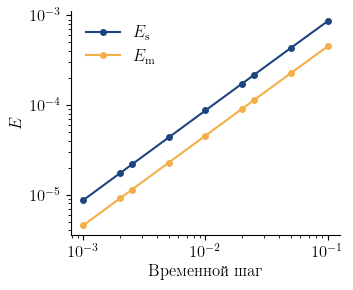

In [7]:
fig, ax = plt.subplots(figsize=(88 * mm2inch, 74 * mm2inch))

plt.plot(
    time_steps, t_errors_cs, marker="o", ms=4, label=r"$E_\mathrm{s}$", color=cmap(0)
)
plt.plot(
    time_steps, t_errors_cm, marker="o", ms=4, label=r"$E_\mathrm{m}$", color=cmap(4)
)

plt.xscale("log")
plt.yscale("log")
plt.ylabel(r"$E$")
plt.xlabel("Временной шаг")
plt.legend(loc="upper left")

plt.savefig("../../../Thesis/images/MMS_c.pdf", bbox_inches="tight", pad_inches=0.02)
plt.show()